In [1]:
import numpy as np
import cv2
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
base_dir = "Images"
train_dir = os.path.join(base_dir, 'Train')
test_dir = os.path.join(base_dir, 'Test')

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 150 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [5]:
img_input = layers.Input(shape=(150, 150, 3))

x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = Model(img_input, output)
model.compile(loss='binary_crossentropy',
            optimizer=RMSprop(learning_rate=0.01), ##########
            metrics=['acc'])

In [6]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=5,
    epochs=10,
    validation_data=test_generator,
    validation_steps=5, #########
    verbose=2)

C:\Users\91798\AppData\Local\Temp\ipykernel_20608\2906203320.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10


5/5 - 8s - loss: 15395.8232 - acc: 0.3444 - val_loss: -7.0039e+02 - val_acc: 0.3400 - 8s/epoch - 2s/step
Epoch 2/10
5/5 - 5s - loss: 532.7685 - acc: 0.3778 - val_loss: -7.2500e+02 - val_acc: 0.3700 - 5s/epoch - 1s/step
Epoch 3/10
5/5 - 5s - loss: -6.2282e+02 - acc: 0.3700 - val_loss: -2.4475e+03 - val_acc: 0.3300 - 5s/epoch - 1s/step
Epoch 4/10
5/5 - 5s - loss: -4.4886e+02 - acc: 0.4222 - val_loss: -6.9622e+03 - val_acc: 0.6400 - 5s/epoch - 966ms/step
Epoch 5/10
5/5 - 5s - loss: 1241.3431 - acc: 0.4778 - val_loss: -5.6481e+03 - val_acc: 0.6600 - 5s/epoch - 1s/step
Epoch 6/10
5/5 - 5s - loss: -6.0765e+03 - acc: 0.5111 - val_loss: -1.3524e+05 - val_acc: 0.3500 - 5s/epoch - 932ms/step
Epoch 7/10
5/5 - 5s - loss: -4.9855e+04 - acc: 0.4300 - val_loss: -9.9442e+05 - val_acc: 0.4200 - 5s/epoch - 949ms/step
Epoch 8/10
5/5 - 5s - loss: -2.3693e+06 - acc: 0.3111 - val_loss: -1.2709e+07 - val_acc: 0.6800 - 5s/epoch - 938ms/step
Epoch 9/10
5/5 - 5s - loss: -9.0952e+06 - acc: 0.4500 - 

Text(0.5, 1.0, 'Training and validation loss')

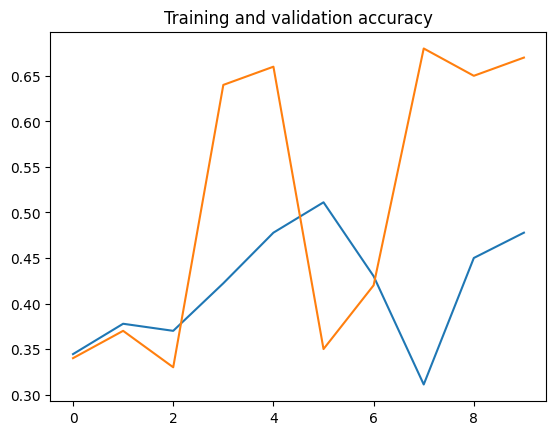

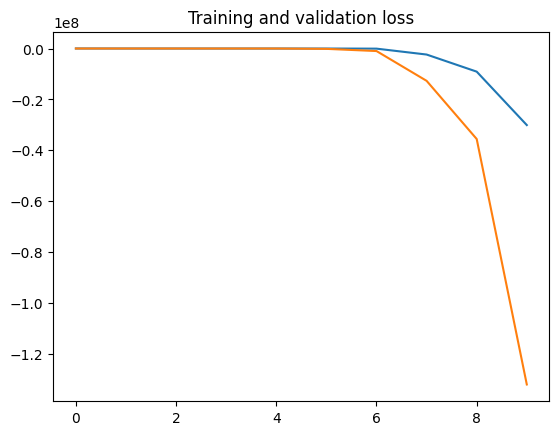

In [7]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [8]:
def preprocess(file_path):
    byte_img = tf.io.read_file(str(file_path))
    # img  = tf.io.decode_jpeg(byte_img)
    img = tf.image.decode_jpeg(byte_img)
    img = tf.image.resize(img, (150, 150))
    img=  img / 255.0
    return img

In [9]:

def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for file in os.listdir(os.path.join('Images', 'Test')):
        for image in os.listdir(os.path.join('Images', 'Test', file)):
        
            # Images/Input_Image/input_image.jpeg
            input_img = preprocess(os.path.join('Images/Input_Image', 'input_image.jpeg'))
            validation_img = preprocess(os.path.join('Images', 'Test', file, image))
            
        # Make Predictions
        result_input_img = model.predict(list(np.expand_dims([input_img], axis=1)))
        result_validation_img = model.predict(list(np.expand_dims([validation_img], axis=1)))
        # results.append(result)
    # print(result_input_img, result_validation_img)

    # Detection Threshold: Metric above which a prediciton is considered positive
    detection = np.sum(np.array(result_input_img) > detection_threshold)
    # print("detection: " , detection)
    # print(np.array(result_input_img))

    # Verification Threshold: Proportion of positive predictions / total positive samples
    verification = detection / len(os.listdir(os.path.join("Images", 'Train/Bharat')))
    # print(verification)
    verified = verification > verification_threshold

    return results, verified

In [10]:
model.save("CNN_model.keras")

In [13]:
import cv2
import xlsxwriter
import time
import mediapipe as mp
import os
cap = cv2.VideoCapture(0)

mpDraw = mp.solutions.drawing_utils
mpFaceMesh = mp.solutions.holistic
# FaceMesh =  mpFaceMesh.FaceMesh(max_num_faces=1)
holistic_model = mpFaceMesh.Holistic(
    min_tracking_confidence= 0.5,
    min_detection_confidence=0.5
)
drawSpec = mpDraw.DrawingSpec(thickness=1, circle_radius=1)

pTime = 0
flag = False
while True:
    ret, frame = cap.read()
    # frame = frame[120:120+250,200:200+250, :]
    if not ret:
        print("Error: Unable to capture frame from webcam.")
        break
    
    # FPS
    cTime = time.time()
    fps = 1/ (cTime - pTime)
    pTime = cTime
    cv2.putText(frame, f"FPS: {int(fps)}", (20, 70), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)

    cv2.imshow('Face Detection', frame)
    if cv2.waitKey(1) == ord('q'):
        break
    if cv2.waitKey(1) == ord('v'):
        cv2.imwrite(os.path.join("Images", "Input_Image", "input_image.jpeg"), frame)
        input_frame = cv2.imread("Images\\Input_Image\\input_image.jpeg")
        imgRGB = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)
        media_results = holistic_model.process(imgRGB)
        if media_results.face_landmarks:
            results, verified = verify(model, 0.01, 0.01)
            print(verified)
        else:
            print("False")
    
# name = input("Enter your name: ")
# workbook = xlsxwriter.Workbook(f"{name}.xlsx")
# worksheet = workbook.add_worksheet()

# if flag:
#     worksheet.write('Bharat', 'Present')
# else:
#     worksheet.write('Bharat', "Absent")
# workbook.close()
# print("Done")
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 42ms/step
True
False


In [ ]:
# import xlsxwriter module
import xlsxwriter
name = input("Enter your name: ")
workbook = xlsxwriter.Workbook(f"{name}.xlsx")
worksheet = workbook.add_worksheet()

if flag:
    worksheet.write('Bharat', 'Present')
else:
    worksheet.write('Bharat', "Present")
workbook.close()


In [ ]:
!pip install xlsxwriter